In [1]:
from luxai_s2.env import LuxAI_S2
from lux.kit import obs_to_game_state, GameState, EnvConfig
from lux.utils import direction_to, my_turn_to_place_factory
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def interact(env, agents, steps):
    # reset our env
    obs = env.reset(seed=41)
    step = 0
    # Note that as the environment has two phases, we also keep track a value called 
    # `real_env_steps` in the environment state. The first phase ends once `real_env_steps` is 0 and used below

    # iterate until phase 1 ends
    while env.state.real_env_steps < 0:
        if step >= steps: break
        actions = {}
        for player in env.agents:
            o = obs[player]
            a = agents[player].early_setup(step, o)
            actions[player] = a
        step += 1
        obs, rewards, dones, infos = env.step(actions)
    done = False
    while not done:
        if step >= steps: break
        actions = {}
        for player in env.agents:
            o = obs[player]
            a = agents[player].act(step, o)
            actions[player] = a
        step += 1
        obs, rewards, dones, infos = env.step(actions)
        done = dones["player_0"] and dones["player_1"]
    return

In [101]:
%load_ext autoreload
%autoreload 2
env = LuxAI_S2() # create the environment object
obs = env.reset(seed=768) # resets an environment with a seed
from agent import Agent
agents = {player: Agent(player, env.state.env_cfg) for player in env.agents}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [102]:
obs_to_game_state

<function lux.kit.obs_to_game_state(step, env_cfg: lux.config.EnvConfig, obs)>

In [103]:
interact(env, agents, 1)

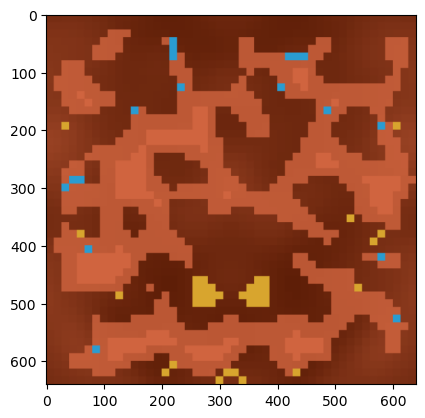

In [104]:
img = env.render("rgb_array", width=640, height=640)
plt.imshow(img)

In [105]:
(game_state.board.rubble == 0)[10:21,12:21]

array([[False, False, False, False, False, False, False,  True,  True],
       [False, False, False, False, False, False,  True,  True,  True],
       [False, False, False, False, False,  True,  True,  True,  True],
       [False, False, False,  True,  True, False, False, False, False],
       [False, False, False,  True,  True, False, False, False, False],
       [False, False, False,  True,  True, False, False, False, False],
       [False, False, False,  True,  True, False, False, False, False],
       [False, False, False,  True,  True, False, False, False, False],
       [False, False, False,  True,  True, False, False, False, False],
       [ True,  True,  True,  True,  True, False, False, False, False],
       [ True,  True,  True,  True,  True,  True, False, False, False]])

In [56]:
(game_state.board.rubble == 0)[10:21,13:20]

array([[False, False, False, False, False, False,  True],
       [False, False, False, False, False,  True,  True],
       [False, False, False, False,  True,  True,  True],
       [False, False,  True,  True, False, False, False],
       [False, False,  True,  True, False, False, False],
       [False, False,  True,  True, False, False, False],
       [False, False,  True,  True, False, False, False],
       [False, False,  True,  True, False, False, False],
       [False, False,  True,  True, False, False, False],
       [ True,  True,  True,  True, False, False, False],
       [ True,  True,  True,  True,  True, False, False]])

In [63]:
(game_state.board.rubble == 0)[20,15]

True

In [ ]:
(game_state.board.rubble == 0)[10:21,15:20]

In [ ]:
#build heavy. if you're a heavy go to nearest ore and mine

In [11]:
env.state.get_obs().keys()

dict_keys(['units', 'teams', 'factories', 'board', 'real_env_steps', 'global_id'])

In [5]:
game_state = obs_to_game_state(15, env.state.env_cfg, env.state.get_obs())

In [19]:
game_state.teams['player_1'].place_first

False

In [17]:
print(game_state.board.rubble == 0)

[[False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False False False False False False False False False]
 [False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False False False False False False False False False]
 [False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False False False False False False False False False]
 [False False False False False False False False False False False False
  False False False False False Fal

In [89]:
zero_rubble_tiles_found=[]




def find_0_rubble(x, y, rubble_board, already_explored, journey_count, limit):
    if journey_count == limit:
        return
    for i in [-1,0,1]:
        for j in [-1,0,1]:
            new_x = x + i 
            new_y = y + j
            if((new_x)<0 or (new_x)>=48 or (new_y)<0 or (new_y)>=48):
                continue 
            if [new_x, new_y] in already_explored or rubble_board[new_x, new_y]!=0 or (new_x==0 and new_y==0) or (new_x==1 and new_y==1) or (new_x==-1 and new_y==-1) or (new_x==1 and new_y==-1) or (new_x==-1 and new_y==1):
                continue 
            else:
                zero_rubble_tiles_found.append((new_x,new_y))
                already_explored.append((new_x,new_y))
                find_0_rubble(new_x, new_y, rubble_board, already_explored, journey_count+1, limit)


In [119]:
zero_rubble_tiles_found=[]
find_0_rubble(best_tiles[1][0],best_tiles[1][1],rubble_board,already_explored=[],journey_count=0,limit=4)
len(set(zero_rubble_tiles_found))

81

In [64]:
rubble_board = game_state.board.rubble == 0

In [98]:
find_0_rubble(20, 15, rubble_board, already_explored=[], journey_count=0, limit=4)


In [116]:
best_tiles = []
most_0_rubble_spots = 0
for fac_tile in best_factory_tiles:
    zero_rubble_tiles_found=[]
    zero_rubble_spots = find_0_rubble(fac_tile[0],fac_tile[1],rubble_board,already_explored=[],journey_count=0,limit=4)
    zero_rubble_spots=len(set(zero_rubble_tiles_found))
    if(zero_rubble_spots > most_0_rubble_spots):
        best_tiles=[fac_tile]
        most_0_rubble_spots=zero_rubble_spots
    elif(zero_rubble_spots==most_0_rubble_spots):
        best_tiles.append(fac_tile)


In [117]:
best_tiles

[(4, 21), (16, 4), (16, 5), (43, 14), (43, 31)]

In [114]:
fac_tile[0]

2

In [115]:
fac_tile

(2, 22)

In [109]:
potential_factory_tiles = list(zip(*np.where(obs['player_0']["board"]["valid_spawns_mask"] == 1)))
smallest_distance = np.inf
best_factory_tiles = []
ice_tiles = np.argwhere(game_state.board.ice==1)
for potential_factory_tile in potential_factory_tiles:
    ice_tile_distances = np.mean((ice_tiles - potential_factory_tile)**2,1)
    closest_ice_distance = np.min(ice_tile_distances)
    #closest_ore_tile = np.argmin(ore_tile_distances) don't actually use these
    #closest_ore_tile_pos = ore_tiles[closest_ore_tile]
    if(closest_ice_distance < smallest_distance):
        smallest_distance = closest_ice_distance
        best_factory_tiles = [potential_factory_tile]
    elif(closest_ice_distance == smallest_distance):
        best_factory_tiles.append(potential_factory_tile)

In [112]:
best_factory_tiles

[(2, 22),
 (3, 21),
 (4, 21),
 (5, 30),
 (6, 43),
 (11, 12),
 (16, 3),
 (16, 4),
 (16, 5),
 (17, 9),
 (30, 9),
 (31, 5),
 (32, 5),
 (33, 5),
 (36, 12),
 (43, 14),
 (43, 31),
 (45, 39)]

In [99]:
len(set(zero_rubble_tiles_found))

70

In [100]:
len(zero_rubble_tiles_found)

12462

In [83]:
(game_state.board.rubble == 0)[10:21,13:20]

array([[False, False, False, False, False, False,  True],
       [False, False, False, False, False,  True,  True],
       [False, False, False, False,  True,  True,  True],
       [False, False,  True,  True, False, False, False],
       [False, False,  True,  True, False, False, False],
       [False, False,  True,  True, False, False, False],
       [False, False,  True,  True, False, False, False],
       [False, False,  True,  True, False, False, False],
       [False, False,  True,  True, False, False, False],
       [ True,  True,  True,  True, False, False, False],
       [ True,  True,  True,  True,  True, False, False]])

In [84]:
(game_state.board.rubble == 0)

SyntaxError: invalid syntax (788038562.py, line 1)

In [73]:
x=set([4,5])

In [74]:
x

{4, 5}

In [29]:
x.union(set([6, 7, 8]))

{1, 2, 3, 6, 7, 8}

In [ ]:
#if within 1 tile an diagonal, skip
#else go out in every direction and get set of tiles that 0 rubble. then go out and explore on direction and get set, 5 times